# Specific Clause Investigation: Governing Law

In [1]:
#Import required packages
from DownloadCUAD import DownloadCUAD
from UsefulProjectFunctions import print_class_samples, write_vector


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS# Generate word cloud
import re
import string

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import AgglomerativeClustering

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RichardWarburton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Section 1: Download Data

In [2]:
#Download CUAD Data to local drive
DC = DownloadCUAD()
DC.setup()

CUAD data downloading...
CUAD data downloaded & extracted!


In [3]:
#Extract annotations for specific clause and the coresponding contracts 
clause_of_interest = 'Governing Law'

#Concatenate string where there are multiple annotations.
contracts,combined_annotations = DC.extract_clause(clause_of_interest,True)

There are 437 contracts with 'Governing Law' annotations
There are 25 contracts with more than one annotation


In [4]:
combined_annotations = np.array(list(map(lambda x: re.sub('\\t|\\r|\\n|[^\S]{2,}',' ',x),combined_annotations)))
combined_annotations = np.array(list(map(lambda x: x.translate(str.maketrans('', '', string.punctuation)),combined_annotations)))


## Section 2: Vectorizing The Clause Data

### 2.1: Simple TFIDF Vectorisation Of The Clause

The approach here will be to apply a TDIF vectorisation to the whole clause text (with stop words removed)and see if we are able to spot any patterns emerge when we plot the resulting feature space in 2D using a TSNE plot.  A range of maximum features (5,15,30,50) and n grams ((1,2),(1,3),(1,4) will be used in this investigation. 

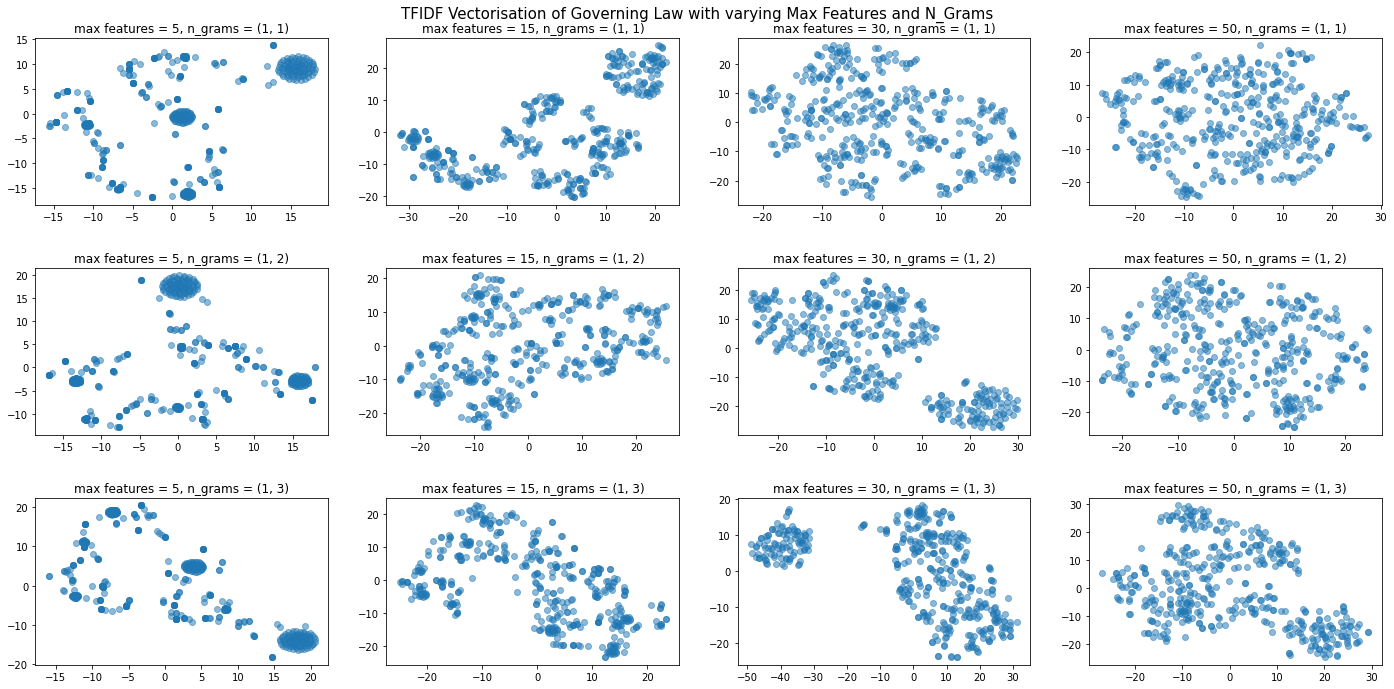

In [5]:
#Define max feature and n_gram ranges
max_features = [5,15,30,50]
n_grams = [(1,1),(1,2),(1,3)]

#Initate plot
fig, axs = plt.subplots(len(n_grams),len(max_features), figsize = (20,10))

#For each pair of max_features and n_grams
for i in range(len(max_features)):
  for j in range(len(n_grams)):

    #TFIDF vectorize the annotation
    vectorizer = TfidfVectorizer(ngram_range = n_grams[j],stop_words ='english',max_features=max_features[i])
    X = vectorizer.fit_transform(combined_annotations).toarray()  

    #Reduce dimension wiht TSNE to 2D
    X_tsne = TSNE(n_components=2).fit_transform(X)
    x = X_tsne[:,0]
    y = X_tsne[:,1]

    #Plot respective parameters
    axs[j,i].scatter(x, y, alpha = 0.5)
    axs[j,i].set_title('max features = {}, n_grams = {}'.format(*(max_features[i],n_grams[j])))

#Format plot
plt.tight_layout(pad=3.0)
plt.suptitle('TFIDF Vectorisation of {} with varying Max Features and N_Grams\n\n'.format(clause_of_interest),size = 15)
plt.show()

We see quite a pronounced clustering appear with two distinct classes at max_features = 30 and 5 across all n grams

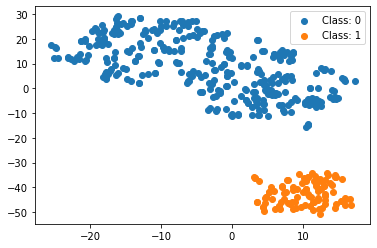

In [6]:
selected_max_features = 30
selected_n_gram = (1,3)
n_clusters = 2

vectorizer = TfidfVectorizer(ngram_range = selected_n_gram,stop_words ='english',max_features=selected_max_features)
X = vectorizer.fit_transform(combined_annotations).toarray()  

#Reduce dimension wiht TSNE to 2D
X_tsne = TSNE(n_components=2).fit_transform(X)

#Fit agglomerative clister model with two clusters to split groups
cluster = AgglomerativeClustering(n_clusters = n_clusters).fit(X_tsne)

x = X_tsne[:,0]
y = X_tsne[:,1]
labels = cluster.labels_

for i in np.unique(labels):
  idx = labels == i
  plt.scatter(x[idx],y[idx],label = 'Class: {}'.format(str(i)))

plt.legend()
plt.show()

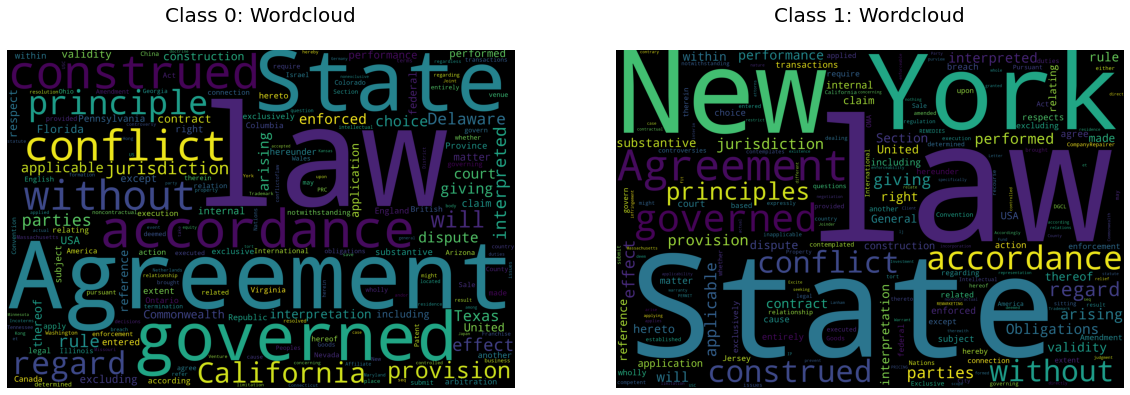

In [7]:
classes = np.unique(labels)
num_classes = np.unique(labels).shape[0]

fig, axs = plt.subplots(1,num_classes, figsize = (20,10))

for cl in classes:
    text = ' '.join(combined_annotations[labels==cl])
    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,collocations=False, stopwords = STOPWORDS).generate(text)# Plot
    
    #plot wordcloud
    axs[cl].imshow(wordcloud)
    axs[cl].set_title('Class {}: Wordcloud\n'.format(str(cl)),size = 20)
    axs[cl].axis('off')

plt.show()

Investigating the count of tokens visually via a word cloud, we can see that Class 1 has identified contracts where the Governing Law is 'New York' and class 0 has identified the states and countries.

While this insight may be of some use and could simplify a workflow process, it would be beneficial to have a more granular classification of governing law. 


### 2.2: Named Entity Recognition

Intuitively, we would expect the governing law to either be a country, or a state within a country.  This opens up the possibility of using ‘Named Entity Recognition’ processes to extract any elements from the text that look like a country.  

By collating these extracted data points, we can build a new feature vector that will potentially be more descriptive of the governing law of the contract.

**Method:**
1. Using Spacy, parse the annotation for entities that look like a country ('GPE') or language (‘LANGUAGE’).
2. If no entities are found, return a null string.
3. Collate these new features for all annotations and return a new feature vector for use in the model


In [8]:
nlp = en_core_web_sm.load()

#Build new features
new_features = []

for annotation in combined_annotations:
    annotation_GPEs = []

    doc = nlp(repr(annotation))
    for X in doc.ents:
        #First pass to capture entities
        if X.label_ == 'GPE' or X.label_ == 'LANGUAGE':
            if X.text not in annotation_GPEs:
                annotation_GPEs.append(X.text)
  
    new_features.append(' '.join(annotation_GPEs))

In [9]:
#Count number of annotations where a GPE or LANGUAGE has not been extracted
not_mapped_count = list(map(lambda x : 1 if x == '' else 0, new_features))

#Output mapping analysis
print('{} out of {} not mapped via process ({:.2%})'.format(*(sum(not_mapped_count),len(not_mapped_count),
                                                              sum(not_mapped_count)/len(not_mapped_count))))

62 out of 437 not mapped via process (14.19%)


In [10]:
#Define stopwords list
stop_words = stopwords.words('english') +['hereof','thereof']

def remove_stop_words(x):
    """Function to remove stop words from a string x """  
    return ' '.join([word for word in x.split(sep=' ') if word not in stop_words])

def coerce_tokens(x):
    ret = x.replace('new york','newyork')
    ret = ret.replace('new jersey','newjersey')
    ret = ret.replace('hong kong','hongkong')
    ret = ret.replace('san antonio','sanantonio')
    return ret

In [11]:
#Clean New Features
new_features = list(map(lambda x: x.lower(),new_features))
new_features = list(map(remove_stop_words,new_features))
new_features = list(map(coerce_tokens,new_features))

#initiate new_features as an np array
new_features = np.array(new_features)

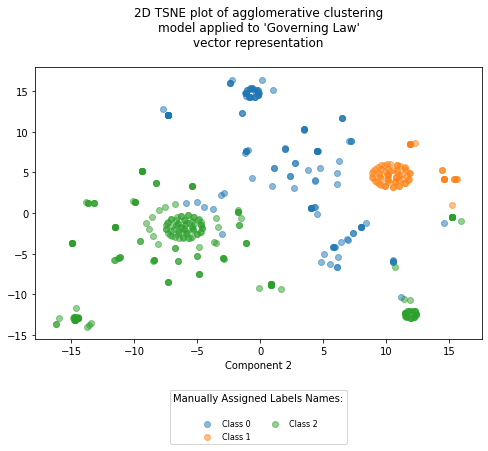

In [12]:
#Define number of clusters
n_clusters = 3

#Count Vectorize new_feature vector
cv = CountVectorizer(stop_words = stop_words)
vectorized_features = cv.fit_transform(new_features).toarray()

#Reduce dimension wiht TSNE to 2D
X_tsne = TSNE(n_components=2).fit_transform(vectorized_features)
x = X_tsne[:,0]
y = X_tsne[:,1]

#Fit agglomerative clister model with two clusters to split groups
cluster = AgglomerativeClustering(n_clusters=n_clusters).fit(vectorized_features)

#Get data points for plot
x = X_tsne[:,0]
y = X_tsne[:,1]
labels = cluster.labels_

plt.figure(figsize =(8,5))
#Plot, highlighting each labeld class
for i in np.unique(labels):
  idx = labels == i
  plt.scatter(x[idx],y[idx],label = 'Class {}'.format(str(i)),alpha = 0.5)

plt.title('2D TSNE plot of agglomerative clustering\nmodel applied to \'Governing Law\'\nvector representation\n')
plt.xlabel('Component 1')
plt.xlabel('Component 2')

plt.legend(loc ='lower center', bbox_to_anchor = (0.5,-0.4),title='Manually Assigned Labels Names:\n',fontsize = 8,ncol=2)
plt.show()

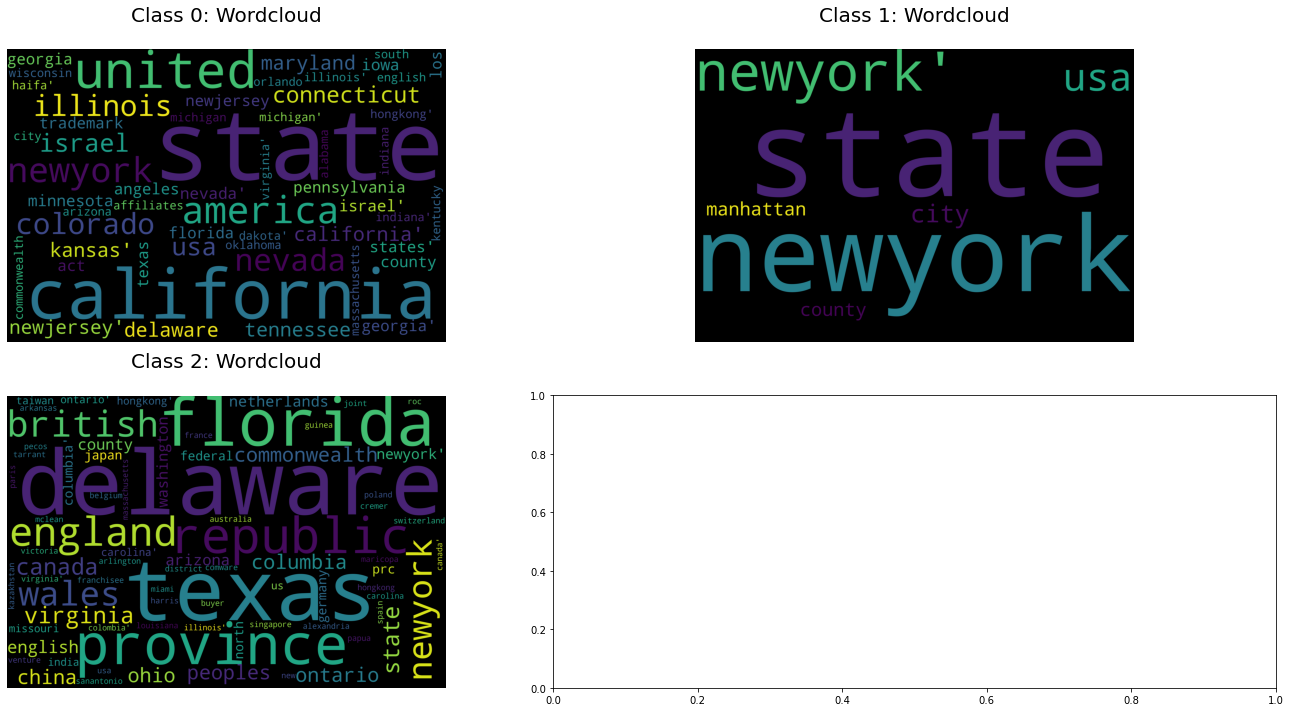

In [13]:
classes = np.unique(labels)
num_classes = np.unique(labels).shape[0]

fig, axs = plt.subplots(2,2, figsize = (20,10))

for cl in classes:
    text = ' '.join(new_features[labels==cl])
    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,collocations=False, stopwords = STOPWORDS).generate(text)# Plot
    i = cl // 2
    j = cl % 2
    
    #plot wordcloud
    axs[i,j].imshow(wordcloud)
    axs[i,j].set_title('Class {}: Wordcloud\n'.format(str(cl)),size = 20)
    axs[i,j].axis('off')
    
plt.tight_layout()
plt.show()

## Output Vectorization

In [14]:
write_vector(list(contracts),list(map(list,vectorized_features)),clause_of_interest)